<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

In [1]:
from __future__ import print_function

%matplotlib inline
import numpy
import matplotlib.pyplot as plt
import warnings
import sympy
sympy.init_printing()

# Root Finding and Optimization

Our goal in this section is to develop techniques to approximate the roots of a given function $f(x)$.  That is find solutions $x$ such that $f(x)=0$. At first glance this may not seem like a meaningful exercise, however, this problem arises  in a wide variety of circumstances. 

For example, suppose that you are trying to find a solution to the equation

$$
    x^2 + x = \alpha\sin{x}.
$$

where $\alpha$ is a real parameter.  Simply rearranging, the expression can be rewritten in the form

$$
    f(x) =  x^2 + x -\alpha\sin{x} = 0.
$$

Determining the roots of the function $f(x)$ is now equivalent to determining the solution to the original expression. Unfortunately, a number of other issues arise. In particular,  with non-linear equations, there may be multiple solutions, or no real solutions at all.

The task of approximating the roots of a function can be a deceptively difficult thing to do. For much of the treatment here we will ignore many details such as existence and uniqueness, but you should keep in mind that they are important considerations. 

**GOAL:** 
For this section we will focus on multiple techniques for efficiently and accurately solving the fundamental problem $f(x)=0$ for functions of a single variable.

### Objectives

* Understand the general rootfinding problem as $f(x)=0$
* Understand the equivalent formulation as a fixed point problem $x = g(x)$
* Understand fixed point iteration and its stability analysis
* Understand definitions of convergence and order of convergence
* Understand practical rootfinding algorithms and their convergence
    * Bisection
    * Newton's method
    * Secant method
    * Hybrid methods and scipy.optimize routines (root_scalar) 
* Understand basic Optimization routines
    * Parabolic Interpolation
    * Golden Section Search
    * scipy.optimize routines (minimize_scalar and minimize)

### Example:  Future Time Annuity

Can I ever retire?

$$ A = \frac{P}{(r / m)} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ] $$

* $A$ total value after $n$ years
* $P$ is payment amount per compounding period
* $m$ number of compounding periods per year
* $r$ annual interest rate
* $n$ number of years to retirement



#### Question:

For a fix monthly Payment $P$, what does the minimum interest rate $r$ need to be so I can retire in 20 years with \$1M. 

Set $P = \frac{\$18,000}{12} = \$1500, \quad m=12, \quad n=20$.

$$ 
    A = \frac{P}{(r / m)} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ] 
$$


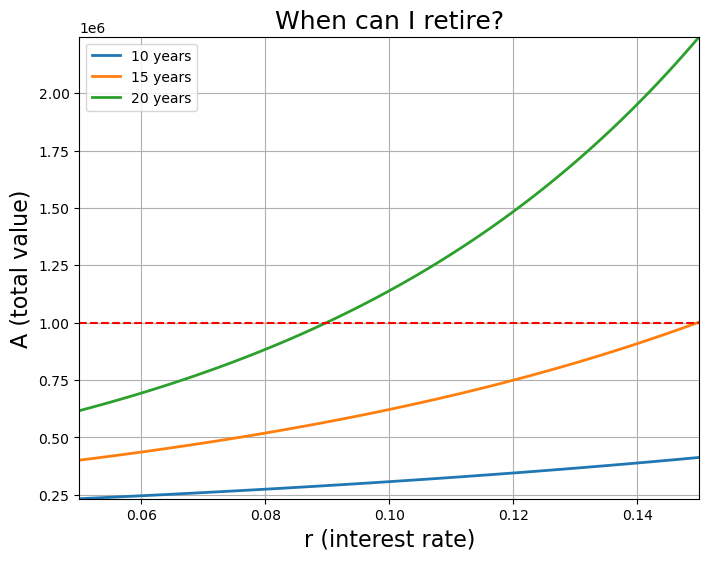

In [2]:
def total_value(P, m, r, n):
    """Total value of portfolio given parameters
    
    Based on following formula:
    
    A = \frac{P}{(r / m)} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n}
                - 1 \right ] 
    
    :Input:
     - *P* (float) - Payment amount per compounding period
     - *m* (int) - number of compounding periods per year
     - *r* (float) - annual interest rate
     - *n* (float) - number of years to retirement
     
     :Returns:
     (float) - total value of portfolio
     
    """
    
    return P / (r / float(m)) * ( (1.0 + r / float(m))**(float(m) * n)
                                 - 1.0)

P = 1500.0
m = 12
n = 20.0
    
r = numpy.linspace(0.05, 0.15, 100)
goal = 1e6

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(r, total_value(P, m, r, 10),label='10 years',linewidth=2)
axes.plot(r, total_value(P, m, r, 15),label='15 years',linewidth=2)
axes.plot(r, total_value(P, m, r, n),label='20 years',linewidth=2)
axes.plot(r, numpy.ones(r.shape) * goal, 'r--')
axes.set_xlabel("r (interest rate)", fontsize=16)
axes.set_ylabel("A (total value)", fontsize=16)
axes.set_title("When can I retire?",fontsize=18)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.set_xlim((r.min(), r.max()))
axes.set_ylim((total_value(P, m, r.min(), 10), total_value(P, m, r.max(), n)))
axes.legend(loc='best')
axes.grid()
plt.show()

## Fixed Point Iteration

How do we go about solving this?

Could try to solve at least partially for $r$:

$$ A = \frac{P}{(r / m)} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ] ~~~~ \Rightarrow ~~~~~$$

$$ r = \frac{P \cdot m}{A} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ] ~~~~ \Rightarrow ~~~~~$$

$$ r = g(r)$$
meaning find a value of r that when plug in you get it back

or
$$ g(r) - r = 0$$
and solve for roots

#### Plot these

$$ r = g(r) = \frac{P \cdot m}{A} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ]$$



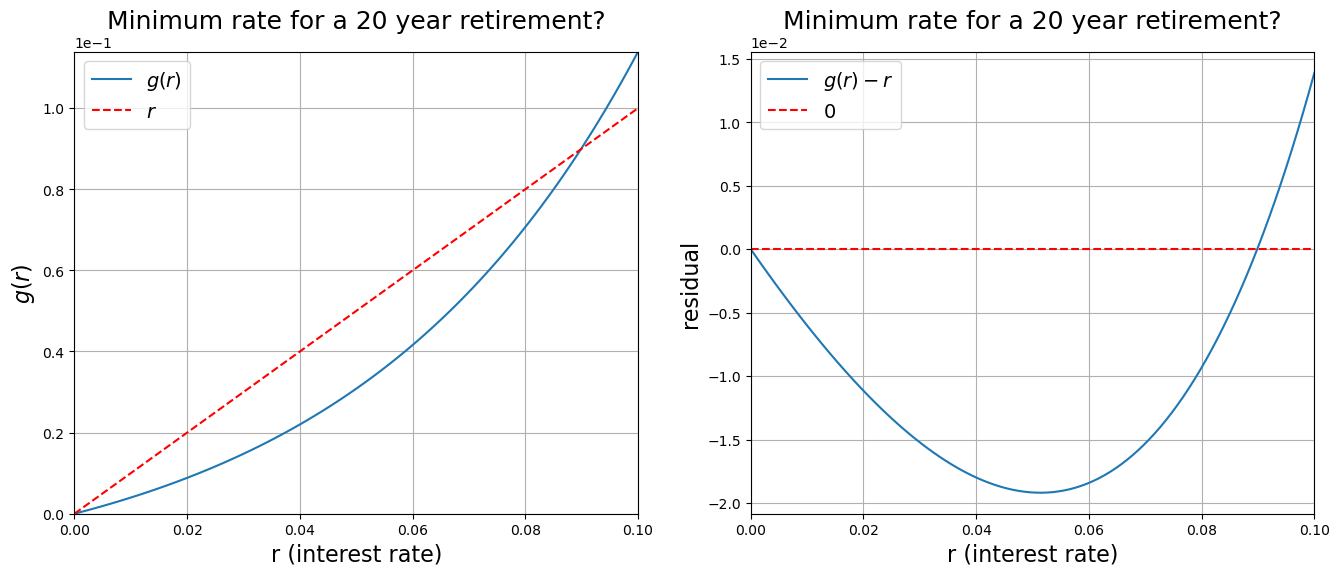

In [3]:
def g(P, m, r, n, A):
    """Reformulated minimization problem
    
    Based on following formula:
    
    g(r) = \frac{P \cdot m}{A} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ]
    
    :Input:
     - *P* (float) - Payment amount per compounding period
     - *m* (int) - number of compounding periods per year
     - *r* (float) - annual interest rate
     - *n* (float) - number of years to retirement
     - *A* (float) - total value after $n$ years
     
     :Returns:
     (float) - value of g(r)
     
    """
    
    return P * m / A * ( (1.0 + r / float(m))**(float(m) * n)
                                 - 1.0)

P = 1500.0
m = 12
n = 20.0
    
r = numpy.linspace(0.00, 0.1, 100)
goal = 1e6

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(r, g(P, m, r, n, goal),label='$g(r)$')
axes.plot(r, r, 'r--',label='$r$')
axes.set_xlabel("r (interest rate)",fontsize=16)
axes.set_ylabel("$g(r)$",fontsize=16)
axes.set_title("Minimum rate for a 20 year retirement?",fontsize=18)
axes.set_ylim([0, 0.12])
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.set_xlim((0.00, 0.1))
axes.set_ylim((g(P, m, 0.00, n, goal), g(P, m, 0.1, n, goal)))
axes.legend(fontsize=14)
axes.grid()

axes = fig.add_subplot(1, 2, 2)
axes.plot(r, g(P, m, r, n, goal)-r,label='$g(r) - r$')
axes.plot(r, numpy.zeros(r.shape), 'r--',label='$0$')
axes.set_xlabel("r (interest rate)",fontsize=16)
axes.set_ylabel("residual",fontsize=16)
axes.set_title("Minimum rate for a 20 year retirement?",fontsize=18)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.set_xlim((0.00, 0.1))
axes.legend(fontsize=14)
axes.grid()
plt.show()

### Question:

A single root $r>0$ clearly exists around $r=0.088$.  But how to find it?

One option might be to take a guess say $r_0 = 0.088$ and form the iterative scheme

$$
\begin{align}
    r_1 &= g(r_0)\\
    r_2 &= g(r_1)\\
        &\vdots \\
    r_{k} &= g(r_{k-1})\\
\end{align}
$$ 
and hope this converges as $k\rightarrow\infty$ (or faster) 

### Easy enough to code


In [4]:
r = 0.088
K = 20
for k in range(K):
    print(r)
    r = g(P,m,r,n,goal)
     
         

0.088
0.08595413598015118
0.08181584708758152
0.07393995779925847
0.060620588978863604
0.04232408431680751
0.023903282768700372
0.011019322624773925
0.004435781760615524
0.00166953516301453
0.0006111365088416604
0.00022135352318931154
7.986318129741709e-05
2.8773622932430686e-05
1.036147291845113e-05
3.73051516348033e-06
1.3430353515948567e-06
4.834991932942678e-07
1.74060547439403e-07
6.266190564829798e-08


### Example 2:

Let $f(x) = x - e^{-x}$, solve $f(x) = 0$

Equivalent to $x = e^{-x}$ or $x = g(x)$ where $g(x) = e^{-x}$

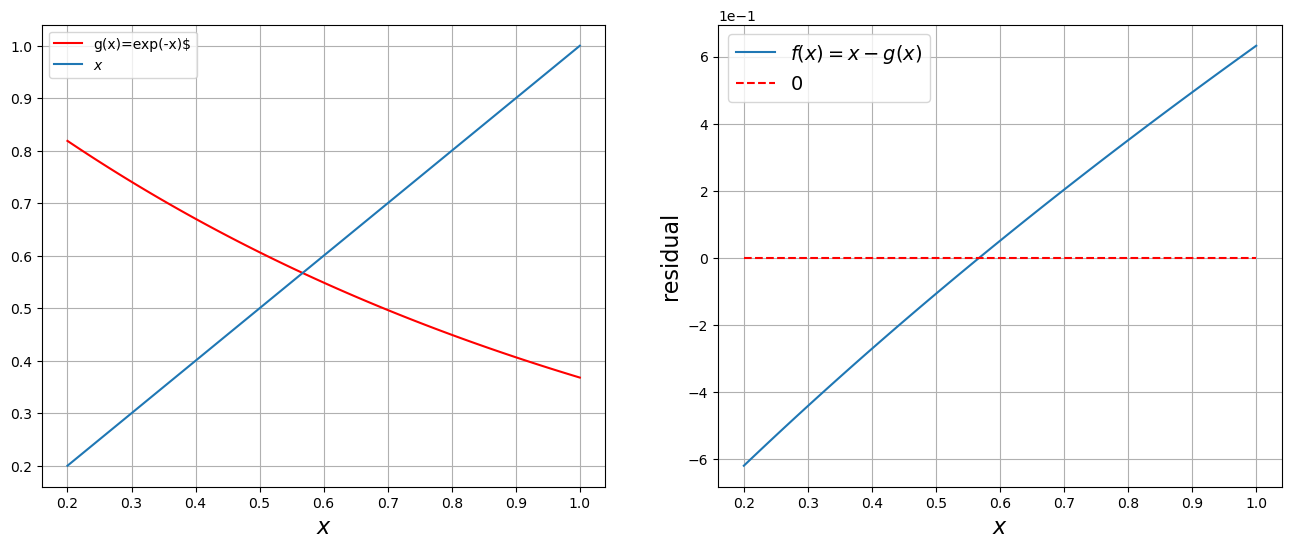

In [5]:
x = numpy.linspace(0.2, 1.0, 100)

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(x, numpy.exp(-x), 'r',label='g(x)=exp(-x)$')
axes.plot(x, x, label='$x$')
axes.set_xlabel("$x$",fontsize=16)
axes.legend()
plt.grid()

f = lambda x : x - numpy.exp(-x)
axes = fig.add_subplot(1, 2, 2)
axes.plot(x, f(x),label='$f(x) = x - g(x)$')
axes.plot(x, numpy.zeros(x.shape), 'r--',label='$0$')
axes.set_xlabel("$x$",fontsize=16)
axes.set_ylabel("residual",fontsize=16)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.legend(fontsize=14)
axes.grid()
plt.show()
plt.show()

#### Again, consider the iterative scheme

set $x_0$ then compute

$$
    x_k = g(x_{k-1})\quad \mathrm{for}\quad k=1,2,3\ldots
$$

or again in code
```python
x = x0
for i in range(N):
    x = g(x)
```

	x	      exp(-x)	    residual
   0.4000000	   0.6703200	   0.2703200
   0.6703200	   0.5115448	   0.1587752
   0.5115448	   0.5995686	   0.0880238
   0.5995686	   0.5490484	   0.0505202
   0.5490484	   0.5774991	   0.0284507
   0.5774991	   0.5613004	   0.0161987


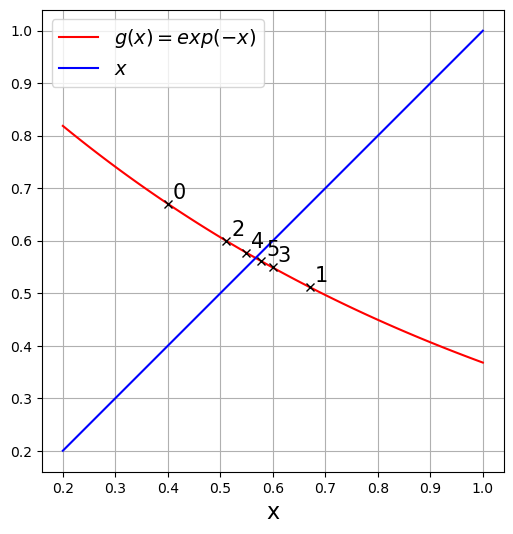

In [6]:
x = numpy.linspace(0.2, 1.0, 100)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, numpy.exp(-x), 'r',label='$g(x)=exp(-x)$')
axes.plot(x, x, 'b',label='$x$')
axes.set_xlabel("x",fontsize=16)
axes.set_aspect('equal')
axes.legend(fontsize=14)

x = 0.4
print('\tx\t      exp(-x)\t    residual')
for steps in range(6):
    residual = numpy.abs(numpy.exp(-x) - x)
    print("{:12.7f}\t{:12.7f}\t{:12.7f}".format(x, numpy.exp(-x), residual))
    axes.plot(x, numpy.exp(-x),'kx')
    axes.text(x+0.01, numpy.exp(-x)+0.01, steps, fontsize="15")
    x = numpy.exp(-x)


plt.grid()
plt.show()

### Example 3:

Let $f(x) = \ln x + x$ and solve $f(x) = 0$ or $x = -\ln x$.

Note that this problem is equivalent to $x = e^{-x}$.

	x	      -log(x)	    residual
   0.5500000	   0.5978370	   0.0478370
   0.5978370	   0.5144371	   0.0833999
   0.5144371	   0.6646819	   0.1502448
   0.6646819	   0.4084467	   0.2562352
   0.4084467	   0.8953939	   0.4869472


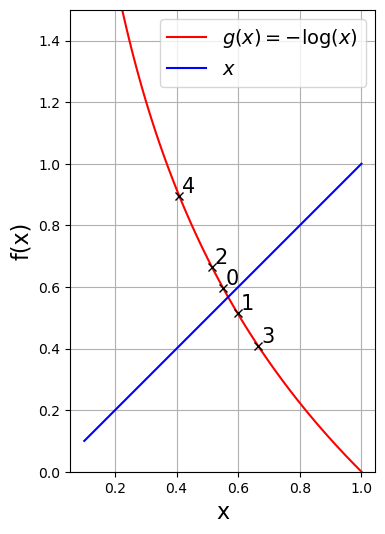

In [7]:
x = numpy.linspace(0.1, 1.0, 100)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, -numpy.log(x), 'r',label='$g(x)=-\log(x)$')
axes.plot(x, x, 'b',label='$x$')
axes.set_xlabel("x",fontsize=16)
axes.set_ylabel("f(x)",fontsize=16)
axes.set_ylim([0, 1.5])
axes.set_aspect('equal')
axes.legend(loc='best',fontsize=14)

x = 0.55
print('\tx\t      -log(x)\t    residual')

for steps in range(5):
    residual = numpy.abs(numpy.log(x) + x)
    print("{:12.7f}\t{:12.7f}\t{:12.7f}".format(x, -numpy.log(x), residual))
    axes.plot(x, -numpy.log(x),'kx')
    axes.text(x + 0.01, -numpy.log(x) + 0.01, steps, fontsize="15")
    x = -numpy.log(x)

plt.grid()    
plt.show()

### These are equivalent problems!  

Something is awry...
Smetimes fixed point iterations work and sometimes they don't.

## Analysis of Fixed Point Iteration

Existence and uniqueness of fixed point problems

*Existence:*

Assume $g \in C[a, b]$, if the range of the mapping $y = g(x)$ satisfies $y \in [a, b] ~~ \forall ~~  x \in [a, b]$ then $g$ has a fixed point in $[a, b]$.

It will converge if when you take a range for one of the functions and then map it to the other function (as in then go to your axis and see how much space the function takes up -- make square) its smaller and as iterate it keeps getting smaller, then it will converge at a fixed point. 

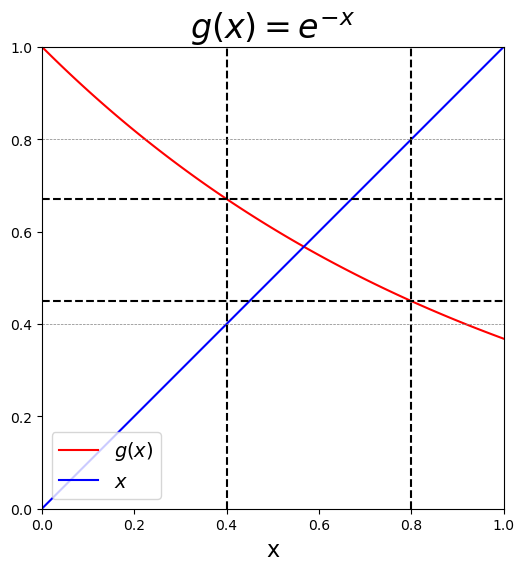

In [8]:
x = numpy.linspace(0.0, 1.0, 100)

# Plot function and intercept
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, numpy.exp(-x), 'r',label='$g(x)$')
axes.plot(x, x, 'b',label='$x$')
axes.set_xlabel("x",fontsize=16)
axes.legend(loc='best',fontsize=14)
axes.set_title('$g(x) = e^{-x}$',fontsize=24)

# Plot domain and range
axes.plot(numpy.ones(x.shape) * 0.4, x, '--k')
axes.plot(numpy.ones(x.shape) * 0.8, x, '--k')
axes.plot(x, numpy.ones(x.shape) * numpy.exp(-0.4), '--k')
axes.plot(x, numpy.ones(x.shape) * numpy.exp(-0.8), '--k')
axes.plot(x, numpy.ones(x.shape) * 0.4, '--',color='gray',linewidth=.5)
axes.plot(x, numpy.ones(x.shape) * 0.8, '--',color='gray',linewidth=.5)


axes.set_xlim((0.0, 1.0))
axes.set_ylim((0.0, 1.0))
axes.set_aspect('equal')

plt.show()

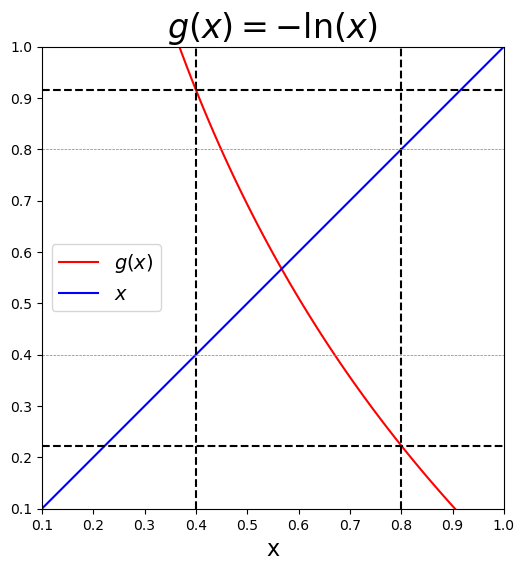

In [9]:
x = numpy.linspace(0.1, 1.0, 100)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, -numpy.log(x), 'r',label='$g(x)$')
axes.plot(x, x, 'b',label='$x$')
axes.set_xlabel("x",fontsize=16)
axes.set_xlim([0.1, 1.0])
axes.set_ylim([0.1, 1.0])
axes.legend(loc='best',fontsize=14)
axes.set_title('$g(x) = -\ln(x)$',fontsize=24)
axes.set_aspect('equal')


# Plot domain and range
axes.plot(numpy.ones(x.shape) * 0.4, x, '--k')
axes.plot(numpy.ones(x.shape) * 0.8, x, '--k')
axes.plot(x, numpy.ones(x.shape) * -numpy.log(0.4), '--k')
axes.plot(x, numpy.ones(x.shape) * -numpy.log(0.8), '--k')
axes.plot(x, numpy.ones(x.shape) * 0.4, '--',color='gray',linewidth=.5)
axes.plot(x, numpy.ones(x.shape) * 0.8, '--',color='gray',linewidth=.5)
plt.show()

*Uniqueness:*

Additionally, suppose $g'(x)$ is defined on $x \in [a, b]$ and $\exists K < 1$ such that

$$
    |g'(x)| \leq K < 1 \quad \forall \quad x \in (a,b)
$$

then $g$ has a unique fixed point $P \in [a,b]$

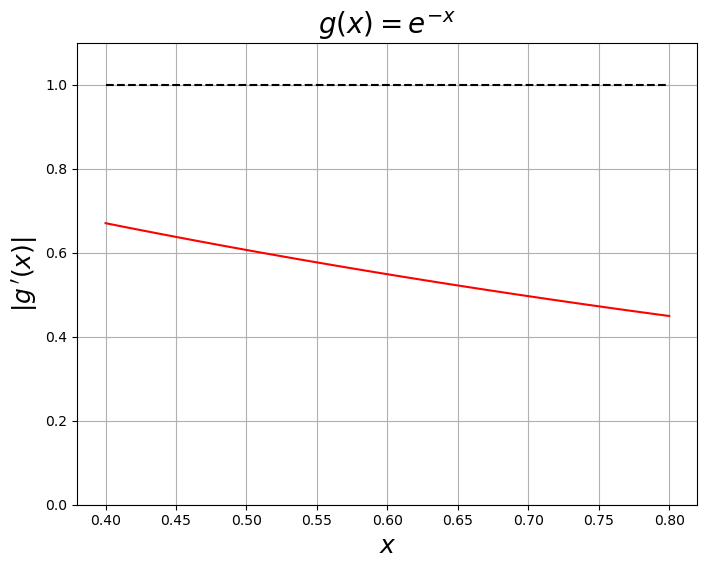

In [10]:
x = numpy.linspace(0.4, 0.8, 100)

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(x, numpy.abs(-numpy.exp(-x)), 'r')
axes.plot(x, numpy.ones(x.shape), 'k--')
axes.set_xlabel("$x$",fontsize=18)
axes.set_ylabel("$|g\,'(x)|$",fontsize=18)
axes.set_ylim((0.0, 1.1))
axes.set_title("$g(x) = e^{-x}$",fontsize=20)
axes.grid()
plt.show()

*Asymptotic convergence*: Behavior of fixed point iterations

$$x_{k+1} = g(x_k)$$
(because $x=g(x)$, iterations says the above and then keeps conitnuing to plug the output into g. We want to know if that will converge at the point)

Assume that a fixed point $x^\ast$ exists, such that  
$$
x^\ast = g(x^\ast)
$$ 

Then define 
$$
    x_{k+1} = x^\ast + e_{k+1} \quad \quad  x_k = x^\ast + e_k
$$
where $e$ is error.

substituting
$$
    x^\ast + e_{k+1} = g(x^\ast + e_k)
$$

Evaluate $$
    g(x^\ast + e_k)
$$

Taylor expand $g(x)$ about $x^\ast$ and substitute $$x = x_k = x^\ast + e_k$$

$$
    g(x^\ast + e_k) = g(x^\ast) + g'(x^\ast) e_k + \frac{g''(x^\ast) e_k^2}{2} + O(e_k^3)
$$

from our definition  $$x^\ast + e_{k+1} = g(x^\ast + e_k)$$ we have
$$
    x^\ast + e_{k+1} = g(x^\ast) + g'(x^\ast) e_k + \frac{g''(x^\ast) e_k^2}{2} +  O(e_k^3)
$$

Note that because $x^* = g(x^*)$ these terms cancel leaving

$$e_{k+1} = g'(x^*) e_k + \frac{g''(x^*) e_k^2}{2}$$

So if $|g'(x^*)| \leq K < 1$ we can conclude that

$$|e_{k+1}| = K |e_k|$$

which shows convergence.  Also note that $K$ is related to $|g'(x^*)|$.

### Convergence of iterative schemes

Given any iterative scheme where

$$|e_{k+1}| = C |e_k|^n$$

If $C < 1$ and:
 - $n=1$ then the scheme is **linearly convergent**
 - $n=2$ then the scheme is **quadratically convergent**
 - $n > 1$ the scheme can also be called **superlinearly convergent**

If $C > 1$ then the scheme is **divergent**



### Examples Revisited

* Example 1:

$$
g(x) = e^{-x}\quad\mathrm{with}\quad x^* \approx 0.56
$$
 
   $$|g'(x^*)| = |-e^{-x^*}| \approx 0.56$$
   

* Example 2: 

$$g(x) = - \ln x \quad \text{with} \quad x^* \approx 0.56$$

   $$|g'(x^*)| = \frac{1}{|x^*|} \approx 1.79$$
   

* Example 3: The retirement problem

$$
    r = g(r) = \frac{P \cdot m}{A} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ]
$$

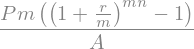

In [15]:
r, P, m, A, n = sympy.symbols('r P m A n')
g_sym = P * m / A * ((1 + r /m)**(m * n) - 1)
g_sym

##NOTE THAT THIS CODE IS ANALYTIC -- CREATES SYMBOLIC FUNCTIONS

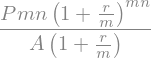

In [16]:
g_prime = g_sym.diff(r)
g_prime

In [17]:
r_star = 0.08985602484084668
print("g'(r*) = ", g_prime.subs({P: 1500.0, m: 12, n:20, A: 1e6, r: r_star})) 
print("g(r*) - r* = {}".format(g_sym.subs({P: 1500.0, m: 12, n:20, A: 1e6, r: r_star}) - r_star))

g'(r*) =  2.14108802539073
g(r*) - r* = 7.00606239689705E-12


* Example 3: The retirement problem

$$
    r = g(r) = \frac{P \cdot m}{A} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ]
$$

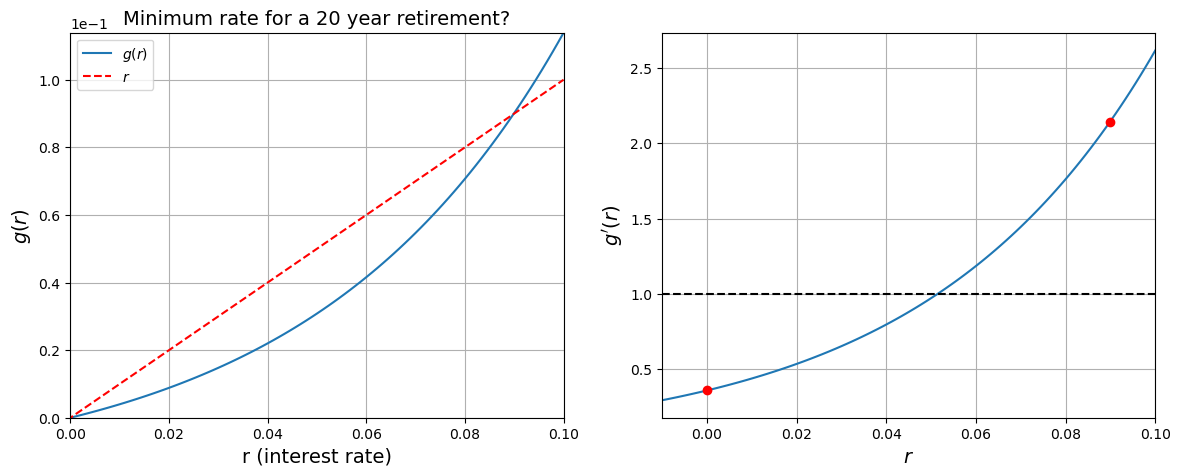

In [14]:
f = sympy.lambdify(r, g_prime.subs({P: 1500.0, m: 12, n:20, A: 1e6}))
g = sympy.lambdify(r, g_sym.subs({P: 1500.0, m: 12, n:20, A: 1e6}))
r = numpy.linspace(-0.01, 0.1, 100)

fig = plt.figure(figsize=(7,5))
fig.set_figwidth(2. * fig.get_figwidth())
axes = fig.add_subplot(1, 2, 1)
axes.plot(r, g(r),label='$g(r)$')
axes.plot(r, r, 'r--',label='$r$')
axes.set_xlabel("r (interest rate)",fontsize=14)
axes.set_ylabel("$g(r)$",fontsize=14)
axes.set_title("Minimum rate for a 20 year retirement?",fontsize=14)
axes.set_ylim([0, 0.12])
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.set_xlim((0.00, 0.1))
axes.set_ylim(g(0.00), g(0.1))
axes.legend()
axes.grid()

axes = fig.add_subplot(1, 2, 2)
axes.plot(r, f(r))
axes.plot(r, numpy.ones(r.shape), 'k--')
axes.plot(r_star, f(r_star), 'ro')
axes.plot(0.0, f(0.0), 'ro')
axes.set_xlim((-0.01, 0.1))
axes.set_xlabel("$r$",fontsize=14)
axes.set_ylabel("$g'(r)$",fontsize=14)
axes.grid()


plt.show()

## Better ways for root-finding/optimization

If $x^*$ is a fixed point of $g(x)$ then $x^*$ is also a *root* of $f(x^*) = g(x^*) - x^*$ s.t. $f(x^*) = 0$.

For instance:

$$f(r) = r - \frac{m P}{A} \left [ \left (1 + \frac{r}{m} \right)^{m n} - 1 \right ] =0 $$

or

$$f(r) = A - \frac{m P}{r} \left [ \left (1 + \frac{r}{m} \right)^{m n} - 1 \right ] =0 $$

## Classical Methods
 - Bisection (linear convergence)
 - Newton's Method (quadratic convergence)
 - Secant Method (super-linear)
 
## Combined Methods
 - RootSafe (Newton + Bisection)
 - Brent's Method (Secant + Bisection)

### Bracketing and Bisection

A **bracket** is an interval $[a,b]$ that contains at least one zero or minima/maxima of interest.  

In the case of a zero the bracket should satisfy 
$$
    \text{sign}(f(a)) \neq \text{sign}(f(b)).
$$

In the case of minima or maxima we need 
$$
    \text{sign}(f'(a)) \neq \text{sign}(f'(b))
$$

**Theorem**:  

Let
$$
    f(x) \in C[a,b] \quad \text{and} \quad \text{sign}(f(a)) \neq \text{sign}(f(b))
$$

then there exists a number 
$$
    c \in (a,b) \quad \text{s.t.} \quad f(c) = 0.
$$
(proof uses intermediate value theorem)

**Example**:  The retirement problem again.  For fixed $A, P, m, n$

$$
    f(r) = A - \frac{P}{(r / m)} \left[ \left(1 + \frac{r}{m} \right)^{m \cdot n} - 1 \right ]
$$

In [ ]:
P = 1500.0
m = 12
n = 20.0
A = 1e6
r = numpy.linspace(0.05, 0.1, 100)
f = lambda r, A, m, P, n: A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(r, f(r, A, m, P, n), 'b')
axes.plot(r, numpy.zeros(r.shape),'r--')
axes.set_xlabel("r", fontsize=16)
axes.set_ylabel("f(r)", fontsize=16)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.grid()

a = 0.075
b = 0.095
axes.plot(a, f(a, A, m, P, n), 'ko')
axes.plot([a, a], [0.0, f(a, A, m, P, n)], 'k--')
axes.plot(b, f(b, A, m, P, n), 'ko')
axes.plot([b, b], [f(b, A, m, P, n), 0.0], 'k--')

plt.show()

Basic bracketing algorithms shrink the bracket while ensuring that the root/extrema remains within the bracket.

What ways could we "shrink" the bracket so that the end points converge to the root/extrema?

#### Bisection Algorithm

Given a bracket $[a,b]$ and a function $f(x)$ - 
1. Initialize with bracket
2. Iterate
   1. Cut bracket in half and check to see where the zero is
   2. Set bracket to new bracket based on what direction we went

##### basic  code
```python
def bisection(f,a,b,tol):
    c = (a + b)/2.  
    f_a = f(a)
    f_b = f(b)
    f_c = f(c)
    
    for step in range(1, MAX_STEPS + 1):
        if numpy.abs(f_c) < tol:
            break
        if numpy.sign(f_a) != numpy.sign(f_c):
            b = c
            f_b = f_c
        else:
            a = c
            f_a = f_c
        c = (a + b)/ 2.0
        f_c = f(c)
    return c
```

### Some real code

In [ ]:
# real code with standard bells and whistles

def bisection(f,a,b,tol = 1.e-6):
    """ uses bisection to isolate a root x of a function of a single variable f such that f(x) = 0.
        the root must exist within an initial bracket a < x < b
        returns when f(x) at the midpoint of the bracket < tol
    
    Parameters:
    -----------
    
    f: function of a single variable f(x) of type float
    a: float
        left bracket a < x
    b: float
        right bracket x < b
        Note:  the signs of f(a) and f(b) must be different to insure a bracket
    tol: float
        tolerance.  Returns when |f((a+b)/2)| < tol
        
    Returns:
    --------
    x: float
        midpoint of final bracket
    x_array: numpy array
        history of bracket centers (for plotting later)
        
    Raises:
    -------
    ValueError:  
        if initial bracket is invalid 
    Warning: 
        if number of iterations exceed MAX_STEPS
    
    """
    MAX_STEPS = 1000
    
    # initialize
    c = (a + b)/2.
    c_array = [ c ]
    
    f_a = f(a)
    f_b = f(b)
    f_c = f(c)
    
    # check bracket
    if numpy.sign(f_a) == numpy.sign(f_b):
        raise ValueError("no bracket: f(a) and f(b) must have different signs")
        
    # Loop until we reach the TOLERANCE or we take MAX_STEPS
    for step in range(1, MAX_STEPS + 1):
        # Check tolerance - Could also check the size of delta_x
        # We check this first as we have already initialized the values
        # in c and f_c
        if numpy.abs(f_c) < tol:
            break

        if numpy.sign(f_a) != numpy.sign(f_c):
            b = c
            f_b = f_c
        else:
            a = c
            f_a = f_c
        c = (a + b)/2.
        f_c = f(c)
        c_array.append(c)
        
    if step == MAX_STEPS:
        warnings.warn('Maximum number of steps exceeded')
    
    return c, numpy.array(c_array)

In [ ]:
# set up function as an inline lambda function
P = 1500.0
m = 12
n = 20.0
A = 1e6
f = lambda r: A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)

# Initialize bracket
a = 0.07
b = 0.10

In [ ]:
# find root
r_star, r_array = bisection(f, a, b, tol=1e-8)
print('root at r = {}, f(r*) = {}, {} steps'.format(r_star,f(r_star),len(r_array)))

In [ ]:
r = numpy.linspace(0.05, 0.11, 100)
# Setup figure to plot convergence
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(r, f(r), 'b')
axes.plot(r, numpy.zeros(r.shape),'r--')
axes.set_xlabel("r", fontsize=16)
axes.set_ylabel("f(r)", fontsize=16)
# axes.set_xlim([0.085, 0.091])
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.plot(a, f(a), 'ko')
axes.plot([a, a], [0.0, f(a)], 'k--')
axes.text(a, f(a), str(0), fontsize="15")

axes.plot(b, f(b), 'ko')
axes.plot([b, b], [f(b), 0.0], 'k--')
axes.text(b, f(b), str(1), fontsize="15")
axes.grid()

# plot out the first N steps
N = 5
for k,r in enumerate(r_array[:N]):
    # Plot iteration
    axes.plot(r, f(r),'kx')
    axes.text(r, f(r), str(k + 2), fontsize="15")
    
axes.plot(r_star, f(r_star), 'go', markersize=10)
axes.set_title('Bisection method:  first {} steps'.format(N), fontsize=20)
plt.show()

What is the smallest tolerance that can be achieved with this routine?  Why?

In [ ]:
# find root
r_star, r_array = bisection(f, a, b, tol=1e-8 )
print('root at r = {}, f(r*) = {}, {} steps'.format(r_star,f(r_star),len(r_array)))

In [ ]:
# this might be useful
print(numpy.diff(r_array))

#### Convergence of Bisection

Generally have
$$
    |e_{k+1}| = C |e_k|^n
$$
where we need $C < 1$ and $n > 0$.

Letting $\Delta x_k$ be the width of the $k$th bracket we can then estimate the error with
$$
    e_k \approx \Delta x_k
$$
and therefore
$$
    e_{k+1} \approx \frac{1}{2} \Delta x_k.
$$
Due to the relationship then between $x_k$ and $e_k$ we then know
$$
    |e_{k+1}| = \frac{1}{2} |e_k|
$$
so therefore the method is linearly convergent.

### Newton's Method (Newton-Raphson)
 - Given a bracket, bisection is guaranteed to converge linearly to a root
 - However bisection uses almost no information about $f(x)$ beyond its sign at a point
 - Can we do "better"? <font color='red'>Newton's method</font>, *when well behaved* can achieve quadratic convergence.
 
**Basic Ideas**: There are multiple interpretations we can use to derive Newton's method
* Use Taylor's theorem to estimate a correction to minimize the residual $f(x)=0$ 
* A geometric interpretation that approximates $f(x)$ locally as a straight line to  predict where $x^*$ might be.
* As a special case of a fixed-point iteration

Perhaps the simplest derivation uses Taylor series.  Consider an initial guess at point $x_k$.  For arbitrary $x_k$, it's unlikely $f(x_k)=0$.  However we can hope there is a correction $\delta_k$ such that at

$$
x_{k+1} = x_k + \delta_k
$$
and 
$$
    f(x_{k+1}) = 0 
$$

expanding in a Taylor series around point $x_k$ 

$$
    f(x_k + \delta_k) \approx  f(x_k) + f'(x_k) \delta_k  + O(\delta_k^2)
$$

substituting into $f(x_{k+1})=0$ and dropping the higher order terms gives

$$
    f(x_k) + f'(x_k) \delta_k  =0
$$

substituting into $f(x_{k+1})=0$ and dropping the higher order terms gives

$$
    f(x_k) + f'(x_k) \delta_k  =0
$$

or solving for the correction
$$
    \delta_k = -f(x_k)/f'(x_k)
$$

which leads to the update for the next iteration
$$
    x_{k+1} = x_k + \delta_k 
$$

or

$$
    x_{k+1} = x_k -f(x_k)/f'(x_k)
$$

rinse and repeat, as it's still unlikely that $f(x_{k+1})=0$ (but we hope the error will be reduced) 

### Algorithm

1. Initialize $x = x_0$
1. While ( $f(x) > tol$ )
  - solve $\delta = -f(x)/f'(x)$
  - update $x \leftarrow x + \delta$


### Geometric interpretation

By truncating the taylor series at first order,  we are locally approximating $f(x)$ as a straight line tangent to the point $f(x_k)$.  If the function was linear at that point, we could find its intercept such that $f(x_k+\delta_k)=0$

In [ ]:
P = 1500.0
m = 12
n = 20.0
A = 1e6
r = numpy.linspace(0.05, 0.11, 100)
f = lambda r, A=A, m=m, P=P, n=n: \
        A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)
f_prime = lambda r, A=A, m=m, P=P, n=n: \
            -P*m*n*(1.0 + r/m)**(m*n)/(r*(1.0 + r/m)) \
                + P*m*((1.0 + r/m)**(m*n) - 1.0)/r**2

# Initial guess
x_k = 0.06

# Setup figure to plot convergence
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(r, f(r), 'b')
axes.plot(r, numpy.zeros(r.shape),'r--')

# Plot x_k point
axes.plot([x_k, x_k], [0.0, f(x_k)], 'k--')
axes.plot(x_k, f(x_k), 'ko')
axes.text(x_k, -5e4, "$x_k$", fontsize=16)
axes.plot(x_k, 0.0, 'xk')
axes.text(x_k, f(x_k) + 2e4, "$f(x_k)$", fontsize=16)
axes.plot(r, f_prime(x_k) * (r - x_k) + f(x_k), 'k')

# Plot x_{k+1} point
x_k = x_k - f(x_k) / f_prime(x_k)
axes.plot([x_k, x_k], [0.0, f(x_k)], 'k--')
axes.plot(x_k, f(x_k), 'ko')
axes.text(x_k, 1e4, "$x_{k+1}$", fontsize=16)
axes.plot(x_k, 0.0, 'xk')
axes.text(0.0873, f(x_k) - 2e4, "$f(x_{k+1})$", fontsize=16)

axes.set_xlabel("r",fontsize=16)
axes.set_ylabel("f(r)",fontsize=16)
axes.set_title("Newton-Raphson Steps",fontsize=18)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.grid()

plt.show()

If we simply approximate the derivative $f'(x_k)$ with its finite difference approximation

$$
    f'(x_k) \approx \frac{0 - f(x_k)}{x_{k+1} - x_k}
$$

we can rearrange to find $x_{k+1}$ as

$$
    x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)}
$$

which is the classic Newton-Raphson iteration

### Some code

In [ ]:
def newton(f,f_prime,x0,tol = 1.e-6):
    """ uses newton's method to find a root x of a function of a single variable f
    
    Parameters:
    -----------
    f: function f(x)
        returns type: float
    f_prime: function f'(x)
        returns type: float
    x0: float
        initial guess
    tolerance: float
        Returns when |f(x)| < tol
        
    Returns:
    --------
    x: float
        final iterate
    x_array: numpy array
        history of iteration points
        
    Raises:
    -------
    Warning: 
        if number of iterations exceed MAX_STEPS
    """
    MAX_STEPS = 200
    
    x = x0
    x_array = [ x0 ]
    for k in range(1, MAX_STEPS + 1):
        x = x  - f(x) / f_prime(x)
        x_array.append(x)
        if numpy.abs(f(x)) < tol:
            break
        
    if k == MAX_STEPS:
        warnings.warn('Maximum number of steps exceeded')
    
    return x, numpy.array(x_array)

### Set the problem up

In [ ]:
P = 1500.0
m = 12
n = 20.0
A = 1e6
f = lambda r, A=A, m=m, P=P, n=n: \
        A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)
f_prime = lambda r, A=A, m=m, P=P, n=n: \
            -P*m*n*(1.0 + r/m)**(m*n)/(r*(1.0 + r/m)) \
                + P*m*((1.0 + r/m)**(m*n) - 1.0)/r**2

### and solve

In [ ]:
x0 = 0.06
x, x_array = newton(f, f_prime, x0, tol=1.e-8)
print('x = {}, f(x) = {}, Nsteps = {}'.format(x, f(x), len(x_array)))


In [ ]:
r = numpy.linspace(0.05, 0.10, 100)

# Setup figure to plot convergence
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(r, f(r), 'b')
axes.plot(r, numpy.zeros(r.shape),'r--')

for n, x in enumerate(x_array):
    axes.plot(x, f(x),'kx')
    axes.text(x, f(x), str(n), fontsize="15") 
          
axes.set_xlabel("r", fontsize=16)
axes.set_ylabel("f(r)", fontsize=16)
axes.set_title("Newton-Raphson Steps", fontsize=18)
axes.grid()
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

axes = fig.add_subplot(1, 2, 2)
axes.semilogy(numpy.arange(len(x_array)), numpy.abs(f(x_array)), 'bo-')
axes.grid()
axes.set_xlabel('Iterations', fontsize=16)
axes.set_ylabel('Residual $|f(r)|$', fontsize=16)
axes.set_title('Convergence', fontsize=18)

plt.show()

What is the smallest tolerance that can be achieved with this routine?  Why?

### Example: 

$$f(x) = x - e^{-x}$$

$$f'(x) = 1 + e^{-x}$$

$$x_{k+1} = x_k - \frac{f(x_k)}{f'(x_k)} = x_k - \frac{x_k - e^{-x_k}}{1 + e^{-x_k}}$$


#### setup in sympy

In [ ]:
x = sympy.symbols('x') 
f = x - sympy.exp(-x)
f_prime = f.diff(x)
f, f_prime

In [ ]:
f = sympy.lambdify(x,f)
f_prime = sympy.lambdify(x,f_prime)
print(f(0.),f_prime(0.))

#### and solve

In [ ]:

x0 = 0.
x, x_array = newton(f, f_prime, x0, tol = 1.e-8)
print('x = {}, f(x) = {}, Nsteps = {}'.format(x, f(x), len(x_array)))

In [ ]:
xa = numpy.linspace(-1,1,100)
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1,2,1)
axes.plot(xa,f(xa),'b')
axes.plot(xa,numpy.zeros(xa.shape),'r--')
axes.plot(x,f(x),'go', markersize=10)
axes.plot(x0,f(x0),'kx',markersize=10)
axes.grid()
axes.set_xlabel('x', fontsize=16)
axes.set_ylabel('f(x)', fontsize=16)
axes.set_title('$f(x) = x - e^{-x}$', fontsize=18)

axes = fig.add_subplot(1, 2, 2)
axes.semilogy(numpy.arange(len(x_array)), numpy.abs(f(x_array)), 'bo-')
axes.grid()
axes.set_xlabel('Iterations', fontsize=16)
axes.set_ylabel('Residual $|f(r)|$', fontsize=16)
axes.set_title('Convergence', fontsize=18)

plt.show()

### Asymptotic Convergence of Newton's Method

Newton's method can be also considered a fixed point iteration

$$x_{k+1} = g(x_k)$$

with  $g(x) = x - \frac{f(x)}{f'(x)}$

Again if $x^*$ is the fixed point and $e_k$ the error at iteration $k$:

$$x_{k+1} = x^* + e_{k+1} \quad \quad x_k = x^* + e_k$$

Taylor Expansion around $x^*$

$$
    x^* + e_{k+1} = g(x^* + e_k) = g(x^*) + g'(x^*) e_k + \frac{g''(x^*) e_k^2}{2!} + O(e_k^3)
$$

Note that as before $x^*$ and $g(x^*)$ cancel:

$$e_{k+1} = g'(x^*) e_k + \frac{g''(x^*) e_k^2}{2!} + \ldots$$

What about $g'(x^*)$ though?  

$$\begin{aligned}
    g(x) &= x - \frac{f(x)}{f'(x)} \\
    g'(x) & = 1 - \frac{f'(x)}{f'(x)} + \frac{f(x) f''(x)}{(f'(x))^2} = \frac{f(x) f''(x)}{(f'(x))^2}
\end{aligned}$$

which evaluated at $x = x^*$ becomes

$$
    g'(x^*) = \frac{f(x^*)f''(x^*)}{f'(x^*)^2} = 0
$$

since $f(x^\ast) = 0$ by definition (assuming $f''(x^\ast)$ and $f'(x^\ast)$ are appropriately behaved).

Back to our expansion we have again

$$
    e_{k+1} = g'(x^*) e_k + \frac{g''(x^*) e_k^2}{2!} + \ldots
$$

which simplifies to 

$$
    e_{k+1} = \frac{g''(x^*) e_k^2}{2!} + \ldots
$$

which leads to 
$$
    |e_{k+1}| < \left | \frac{g''(x^*)}{2!} \right | |e_k|^2
$$

Newton's method is therefore quadratically convergent where  the constant is controlled by the second derivative.

#### Example:  Convergence for a non-simple root

Consider our first problem

$$
    f(x) = x^2 + x - \sin(x)
$$

the case is, unfortunately, not as rosey.  Why might this be?

#### Setup the problem

In [ ]:
f = lambda x: x*x + x - numpy.sin(x)
f_prime = lambda x: 2*x + 1. - numpy.cos(x)
x0 = .9

x, x_array = newton(f, f_prime, x0, tol= 1.e-16)
print('x = {}, f(x) = {}, Nsteps = {}'.format(x, f(x), len(x_array)))

In [ ]:
xa = numpy.linspace(-2,2,100)
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1,2,1)
axes.plot(xa,f(xa),'b')
axes.plot(xa,numpy.zeros(xa.shape),'r--')
axes.plot(x,f(x),'go', markersize=10)
axes.plot(x0,f(x0),'kx', markersize=10)
axes.grid()
axes.set_xlabel('x', fontsize=16)
axes.set_ylabel('f(x)', fontsize=16)
axes.set_title('$f(x) = x^2 +x - sin(x)$', fontsize=18)

axes = fig.add_subplot(1, 2, 2)
axes.semilogy(numpy.arange(len(x_array)), numpy.abs(f(x_array)), 'bo-')
axes.grid()
axes.set_xlabel('Iterations', fontsize=16)
axes.set_ylabel('Residual $|f(r)|$', fontsize=16)
axes.set_title('Convergence', fontsize=18)

plt.show()

### Convergence appears linear, can you show this?:
$$f(x) = x^2 + x -\sin (x)$$


### Example: behavior of Newton with multiple roots
$f(x) = \sin (2 \pi x)$

$$x_{k+1} = x_k - \frac{\sin (2 \pi x_k)}{2 \pi \cos (2 \pi x_k)}= x_k - \frac{1}{2 \pi} \tan (2 \pi x_k)$$

In [ ]:
x = numpy.linspace(0, 2, 1000)
f = lambda x: numpy.sin(2.0 * numpy.pi * x)
f_prime = lambda x: 2.0 * numpy.pi * numpy.cos(2.0 * numpy.pi * x)
x_kp = lambda x: x - f(x)/f_prime(x)

fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(x, f(x),'b')
axes.plot(x, f_prime(x), 'r')
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_title("Comparison of $f(x)$ and $f'(x)$")
axes.set_ylim((-2,2))
axes.set_xlim((0,2))
axes.plot(x, numpy.zeros(x.shape), 'k--')

x_k = 0.3
axes.plot([x_k, x_k], [0.0, f(x_k)], 'ko')
axes.plot([x_k, x_k], [0.0, f(x_k)], 'k--')
axes.plot(x, f_prime(x_k) * (x - x_k) + f(x_k), 'k')

x_k = x_k - f(x_k) / f_prime(x_k)
axes.plot([x_k, x_k], [0.0, f(x_k)], 'ko')
axes.plot([x_k, x_k], [0.0, f(x_k)], 'k--')

axes = fig.add_subplot(1, 2, 2)
axes.plot(x, f(x),'b')
axes.plot(x, x_kp(x), 'r')
axes.set_xlabel("x")
axes.set_ylabel("y")
axes.set_title("Comparison of $f(x)$ and $x_{k+1}(x)$",fontsize=18)
axes.set_ylim((-2,2))
axes.set_xlim((0,2))
axes.plot(x, numpy.zeros(x.shape), 'k--')

plt.show()

### Basins of Attraction

Given a point $x_0$ can we determine if Newton-Raphson converges and to **which root** it converges to?

A *basin of attraction* $X$ for Newton's methods is defined as the set such that $\forall x \in X$ Newton iterations converges to the same root.  Unfortunately this is far from a trivial thing to determine and even for simple functions can lead to regions that are complicated or even fractal.  

In [ ]:
# calculate the basin of attraction for f(x) = sin(2\pi x)

x_root = numpy.zeros(x.shape)
N_steps = numpy.zeros(x.shape)
for i,xk in enumerate(x):
    x_root[i], x_root_array = newton(f, f_prime, xk)
    N_steps[i] = len(x_root_array)


In [ ]:
y = numpy.linspace(-2,2)
X,Y = numpy.meshgrid(x,y)
X_root = numpy.outer(numpy.ones(y.shape),x_root)

plt.figure(figsize=(8, 6))
plt.pcolor(X, Y, X_root,vmin=-5, vmax=5,cmap='seismic')
cbar = plt.colorbar()
cbar.set_label('$x_{root}$', fontsize=18)
plt.plot(x, f(x), 'k-')
plt.plot(x, numpy.zeros(x.shape),'k--', linewidth=0.5)
plt.xlabel('x', fontsize=16)
plt.title('Basins of Attraction: $f(x) = \sin{2\pi x}$', fontsize=18)
#plt.xlim(0.25-.1,0.25+.1)
plt.show()

### Fractal Basins of Attraction

If $f(x)$ is complex (for $x$ complex), then the basins of attraction can be beautiful and fractal

Plotted below are two fairly simple equations which demonstrate the issue:
1. $f(x) = x^3 - 1$
2. Kepler's equation $\theta - e \sin \theta = M$

In [ ]:
f = lambda x: x**3 - 1
f_prime = lambda x: 3 * x**2

N = 1001
x = numpy.linspace(-2, 2, N)
X, Y = numpy.meshgrid(x, x)
R = X + 1j * Y

for i in range(30):
    R = R - f(R) / f_prime(R)

#print(numpy.imag(R))
roots = numpy.roots([1., 0., 0., -1])
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
#axes.contourf(X, Y, numpy.sign(numpy.imag(R))*numpy.abs(R),vmin = -10, vmax = 10)
cf = axes.contourf(X, Y, numpy.real(R), vmin=-8, vmax=8)
axes.scatter(numpy.real(roots), numpy.imag(roots))
axes.set_xlabel("Real")
axes.set_ylabel("Imaginary")
axes.set_title("Basin of Attraction for $f(x) = x^3 - 1$")
axes.grid()
plt.show()

In [ ]:
def f(theta, e=0.083, M=1):
    return theta - e * numpy.sin(theta) - M
def f_prime(theta, e=0.083):
    return 1 - e * numpy.cos(theta)

N = 1001
x = numpy.linspace(-30.5, -29.5, N)
y = numpy.linspace(-17.5, -16.5, N)
X, Y = numpy.meshgrid(x, y)
R = X + 1j * Y

for i in range(30):
    R = R - f(R) / f_prime(R)
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')    
axes.contourf(X, Y, R, vmin = 0, vmax = 10)
axes.set_xlabel("Real")
axes.set_ylabel("Imaginary")
axes.set_title("Basin of Attraction for $f(x) = x - e \sin x - M$")
plt.show()

#### Other Issues

Need to supply both $f(x)$ and $f'(x)$, could be expensive
 
Example:  FTV equation $f(r) = A - \frac{m P}{r} \left[ \left(1 + \frac{r}{m} \right )^{m n} - 1\right]$

Can use symbolic differentiation (`sympy`)

### Secant Methods

Is there a method with the convergence of Newton's method but without the extra derivatives?  What way would you modify Newton's method so that you would not need $f'(x)$?

Given $x_k$ and $x_{k-1}$ represent the derivative as the approximation

$$f'(x) \approx \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}}$$

Combining this with the Newton approach leads to

$$x_{k+1} = x_k - \frac{f(x_k) (x_k - x_{k-1}) }{f(x_k) - f(x_{k-1})}$$

This leads to superlinear convergence and not quite quadratic as the exponent on the convergence is $\approx 1.7$.

Alternative interpretation, fit a line through two points and see where they intersect the x-axis.

$$(x_k, f(x_k)) ~~~~~ (x_{k-1}, f(x_{k-1})$$

$$y = \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}} (x - x_k) + b$$

$$b = f(x_{k-1}) - \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}} (x_{k-1} - x_k)$$

$$ y = \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}} (x - x_k) + f(x_k)$$

Now solve for $x_{k+1}$ which is where the line intersects the x-axies ($y=0$)

$$0 = \frac{f(x_k) - f(x_{k-1})}{x_k - x_{k-1}} (x_{k+1} - x_k) + f(x_k)$$

$$x_{k+1} = x_k - \frac{f(x_k)  (x_k - x_{k-1})}{f(x_k) - f(x_{k-1})}$$

#### Secant Method

$$x_{k+1} = x_k - \frac{f(x_k)  (x_k - x_{k-1})}{f(x_k) - f(x_{k-1})}$$

In [ ]:
P = 1500.0
m = 12
n = 20.0
A = 1e6
r = numpy.linspace(0.05, 0.11, 100)
f = lambda r, A=A, m=m, P=P, n=n: \
        A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)

# Initial guess
x_k = 0.07
x_km = 0.06

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(r, f(r), 'b')
axes.plot(r, numpy.zeros(r.shape),'r--')

axes.plot(x_k, 0.0, 'ko')
axes.plot(x_k, f(x_k), 'ko')
axes.plot([x_k, x_k], [0.0, f(x_k)], 'k--')
axes.plot(x_km, 0.0, 'ko')
axes.plot(x_km, f(x_km), 'ko')
axes.plot([x_km, x_km], [0.0, f(x_km)], 'k--')

axes.plot(r, (f(x_k) - f(x_km)) / (x_k - x_km) * (r - x_k) + f(x_k), 'k')
x_kp = x_k - (f(x_k) * (x_k - x_km) / (f(x_k) - f(x_km)))
axes.plot(x_kp, 0.0, 'ro')
axes.plot([x_kp, x_kp], [0.0, f(x_kp)], 'r--')
axes.plot(x_kp, f(x_kp), 'ro')

axes.set_xlabel("r", fontsize=16)
axes.set_ylabel("f(r)", fontsize=14)
axes.set_title("Secant Method", fontsize=18)
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
axes.grid()

plt.show()

What would the algorithm look like for such a method?

#### Algorithm

Given $f(x)$,   a `TOLERANCE`, and a `MAX_STEPS` 

1. Initialize two points $x_0$, $x_1$, $f_0 = f(x_0)$, and $f_1 = f(x_1)$
2. Loop for k=2, to  `MAX_STEPS` is reached or `TOLERANCE` is achieved
   1. Calculate new update 
   $$x_{2} = x_1 - \frac{f(x_1)  (x_1 - x_{0})}{f(x_1) - f(x_{0})}$$
   2. Check for convergence and break if reached
   3. Update parameters $x_0 = x_1$, $x_1 = x_{2}$, $f_0 = f_1$ and $f_1 = f(x_1)$

#### Some Code


In [ ]:
def secant(f, x0, x1, tol = 1.e-6):
    """ uses a linear secant method to find a root x of a function of a single variable f
    
    Parameters:
    -----------
    f: function f(x)
        returns type: float
    x0: float
        first point to initialize the algorithm
    x1: float
        second point to initialize the algorithm x1 != x0        
    tolerance: float
        Returns when |f(x)| < tol
        
    Returns:
    --------
    x: float
        final iterate
    x_array: numpy array
        history of iteration points
        
    Raises:
    -------
    ValueError:
        if x1 is too close to x0
    Warning: 
        if number of iterations exceed MAX_STEPS
    """
    MAX_STEPS = 200
    
    if numpy.isclose(x0, x1):
        raise ValueError('Initial points are too close (preferably should be a bracket)')
        
    x_array = [ x0, x1 ]
    for k in range(1, MAX_STEPS + 1):
        x2 = x1 - f(x1) * (x1 - x0) / (f(x1) - f(x0))
        x_array.append(x2)
        if numpy.abs(f(x2)) < tol:
            break
        x0 = x1
        x1 = x2
        
    if k == MAX_STEPS:
        warnings.warn('Maximum number of steps exceeded')
    
    return x2, numpy.array(x_array)

### Set the problem up

In [ ]:
P = 1500.0
m = 12
n = 20.0
A = 1e6
r = numpy.linspace(0.05, 0.11, 100)
f = lambda r, A=A, m=m, P=P, n=n: \
        A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)


### and solve

In [ ]:
x0 = 0.06
x1 = 0.07

x, x_array = secant(f, x0, x1, tol= 1.e-7)
print('x = {}, f(x) = {}, Nsteps = {}'.format(x, f(x), len(x_array)))

In [ ]:
r = numpy.linspace(0.05, 0.10, 100)

# Setup figure to plot convergence
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.plot(r, f(r), 'b')
axes.plot(r, numpy.zeros(r.shape),'r--')

for n, x in enumerate(x_array):
    axes.plot(x, f(x),'kx')
    axes.text(x, f(x), str(n), fontsize="15") 
          
axes.set_xlabel("r", fontsize=16)
axes.set_ylabel("f(r)", fontsize=16)
axes.set_title("Secant Method Steps", fontsize=18)
axes.grid()
axes.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

axes = fig.add_subplot(1, 2, 2)
axes.semilogy(numpy.arange(len(x_array)), numpy.abs(f(x_array)), 'bo-')
axes.grid()
axes.set_xlabel('Iterations', fontsize=16)
axes.set_ylabel('Residual $|f(r)|$', fontsize=16)
axes.set_title('Convergence', fontsize=18)

plt.show()

#### Comments

 - Secant method as shown is equivalent to linear interpolation
 - Can use higher order interpolation for higher order secant methods
 - Convergence is not quite quadratic
 - Not guaranteed to converge
 - Does not preserve brackets
 - Almost as good as Newton's method if your initial guess is good.

### Hybrid Methods

Combine attributes of methods with others to make one great algorithm to rule them all (not really)

#### Goals
1. Robustness:  Given a bracket $[a,b]$, maintain bracket
1. Efficiency:  Use superlinear convergent methods when possible

#### Options
 - Methods requiring $f'(x)$
   - NewtSafe (RootSafe, Numerical Recipes)
   - Newton's Method within a bracket, Bisection otherwise
 - Methods not requiring $f'(x)$
   - Brent's Algorithm (zbrent, Numerical Recipes)
     - Combination of bisection, secant and inverse quadratic interpolation
   - `scipy.optimize` package **new** root_scalar

In [ ]:
from scipy.optimize import root_scalar
#root_scalar?

### Set the problem up (again)

In [ ]:
def f(r,A,m,P,n):
    return  A - m * P / r * ((1.0 + r / m)**(m * n) - 1.0)

def f_prime(r,A,m,P,n): 
    return (-P*m*n*(1.0 + r/m)**(m*n)/(r*(1.0 + r/m)) + 
            P*m*((1.0 + r/m)**(m*n) - 1.0)/r**2)
A = 1.e6
m = 12
P = 1500.
n = 20.

Try Brent's method

In [ ]:
a = 0.07
b = 0.1
sol  = root_scalar(f,args=(A,m,P,n), bracket=(a, b), method='brentq')  
print(sol)

Try Newton's method

In [ ]:
sol = root_scalar(f,args=(A,m,P,n), x0=.07, fprime=f_prime, method='newton')
print(sol)

In [ ]:
  f1 = lambda A : f(r,A,m,P,n)

## Optimization (finding extrema)

I want to find the extrema of a function $f(x)$ on a given interval $[a,b]$.

A few approaches:
 - Interpolation Algorithms: Repeated parabolic interpolation
 - Bracketing Algorithms:  Golden-Section Search (linear)
 - Hybrid Algorithms 
 - Use Rootfinding methods on $f'(x)$

### Interpolation Approach

Successive parabolic interpolation - similar to secant method

Basic idea:  Fit polynomial to function using three points, find its minima, and guess new points based on that minima

1. What do we need to fit a polynomial $p_n(x)$ of degree $n \geq 2$?

2. How do we construct the polynomial $p_2(x)$?

3. Once we have constructed $p_2(x)$ how would we find the minimum?

#### Algorithm

Given $f(x)$ and $[x_0,x_1]$ - Note that unlike a bracket these will be a sequence of better approximations to the minimum.
1. Initialize $x = [x_0, x_1, (x_0+x_1)/2]$
1. Loop
   1. Evaluate function $f(x)$ at the three points
   1. Find the quadratic polynomial that interpolates those points: 
   
      $$p(x) = p_0 x^2 + p_1 x + p_2$$

   3. Calculate the minimum: 
      
      $$p'(x) = 2 p_0 x + p_1 = 0 \quad \Rightarrow \quad x^\ast = -p_1 / (2 p_0)$$

   1. New set of points $x = [x_1, (x_0+x_1)/2, x^\ast]$
   1. Check tolerance

### Demo

In [ ]:
def f(t):
    """Simple function for minimization demos"""
    return -3.0 * numpy.exp(-(t - 0.3)**2 / (0.1)**2) \
           +      numpy.exp(-(t - 0.6)**2 / (0.2)**2) \
           +      numpy.exp(-(t - 1.0)**2 / (0.2)**2) \
           +      numpy.sin(t)                        \
           -      2.0

In [ ]:
x0, x1 = 0.5, 0.2
x = numpy.array([x0, x1, (x0 + x1)/2.])
p = numpy.polyfit(x, f(x), 2)
parabola = lambda t: p[0]*t**2 + p[1]*t + p[2]
t_min = -p[1]/2./p[0]

In [ ]:
MAX_STEPS = 100
TOLERANCE = 1e-4

t = numpy.linspace(0., 2., 100)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, f(t), label='$f(t)$')
axes.set_xlabel("t (days)")
axes.set_ylabel("People (N)")
axes.set_title("Decrease in Population due to SPAM Poisoning")
axes.plot(x[0], f(x[0]), 'ko')
axes.plot(x[1], f(x[1]), 'ko')
axes.plot(x[2], f(x[2]), 'ko')
axes.plot(t, parabola(t), 'r--',  label='parabola')
axes.plot(t_min, parabola(t_min), 'ro' )
axes.plot(t_min, f(t_min), 'k+')

axes.legend(loc='best')
axes.set_ylim((-5, 0.0))
axes.grid()
plt.show()

### Rinse and repeat

In [ ]:
MAX_STEPS = 100
TOLERANCE = 1e-4

x = numpy.array([x0, x1, (x0 + x1) / 2.0])

fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, f(t))
axes.set_xlabel("t (days)")
axes.set_ylabel("People (N)")
axes.set_title("Decrease in Population due to SPAM Poisoning")
axes.plot(x[0], f(x[0]), 'ko')
axes.plot(x[1], f(x[1]), 'ko')

success = False
for n in range(1, MAX_STEPS + 1):
    axes.plot(x[2], f(x[2]), 'ko')
    poly = numpy.polyfit(x, f(x), 2)
    axes.plot(t, poly[0] * t**2 + poly[1] * t + poly[2], 'r--')
    x[0] = x[1]
    x[1] = x[2]
    x[2] = -poly[1] / (2.0 * poly[0])
    if numpy.abs(x[2] - x[1]) / numpy.abs(x[2]) < TOLERANCE:
        success = True
        break
    
if success:
    print("Success!")
    print("  t* = %s" % x[2])
    print("  f(t*) = %s" % f(x[2]))
    print("  number of steps = %s" % n)
else:
    print("Reached maximum number of steps!")
    
axes.set_ylim((-5, 0.0))
axes.grid()
plt.show()

#### Some Code


In [ ]:
def parabolic_interpolation(f, bracket, tol = 1.e-6):
    """ uses repeated parabolic interpolation to refine a local minimum of a function f(x)
    this routine uses numpy functions polyfit and polyval to fit and evaluate the quadratics
    
    Parameters:
    -----------
    f: function f(x)
        returns type: float
    bracket: array
        array [x0, x1] containing an initial bracket that contains a minimum   
    tolerance: float
        Returns when relative error of last two iterates < tol 
        
    Returns:
    --------
    x: float
        final estimate of the minima
    x_array: numpy array
        history of iteration points
        
    Raises:
    -------
    Warning: 
        if number of iterations exceed MAX_STEPS
    """
    MAX_STEPS = 100
    
    x = numpy.zeros(3)
    x[:2] = bracket
    x[2] = (x[0] + x[1])/2.
        
    x_array = [ x[2] ]
    for k in range(1, MAX_STEPS + 1):
        poly = numpy.polyfit(x, f(x), 2)
        x[0] = x[1]
        x[1] = x[2]
        x[2] = -poly[1] / (2.0 * poly[0])
        x_array.append(x[2])
        if numpy.abs(x[2] - x[1]) / numpy.abs(x[2]) < tol:
            break
        
    if k == MAX_STEPS:
        warnings.warn('Maximum number of steps exceeded')
    
    return x[2], numpy.array(x_array)

#### set up problem


In [ ]:
bracket = numpy.array([0.2, 0.5])
x, x_array = parabolic_interpolation(f, bracket, tol = 1.e-6)
print("Extremum f(x) = {}, at x = {}, N steps = {}".format(f(x), x, len(x_array)))

In [ ]:
t = numpy.linspace(0, 2, 200)
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, f(t))
axes.plot(x_array, f(x_array),'ro')
axes.plot(x, f(x), 'go')
axes.set_xlabel("t (days)")
axes.set_ylabel("People (N)")
axes.set_title("Decrease in Population due to SPAM Poisoning")
axes.grid()
plt.show()

### Bracketing Algorithm (Golden Section Search)

Given $f(x) \in C[x_0,x_3]$ that is convex (concave) over an interval $x \in [x_0,x_3]$ reduce the interval size until it brackets the minimum (maximum).

Note that we no longer have the $x=0$ help we had before so bracketing and doing bisection is a bit trickier in this case.  In particular choosing your initial bracket is important!

#### Bracket Picking

Say we start with a bracket $[x_0, x_3]$ and pick two new points $x_1 < x_2 \in [x_0, x_3]$.  We want to pick a new bracket that guarantees that the extrema exists in it.  We then can pick this new bracket with the following rules:
 - If $f(x_1) < f(x_2)$ then we know the minimum is between $x_0$ and $x_2$.
 - If $f(x_1) > f(x_2)$ then we know the minimum is between $x_1$ and $x_3$.

In [ ]:
f = lambda x: x**2

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)

search_points = [-1.0, -0.5, 0.75, 1.0]
axes = fig.add_subplot(2, 2, 1)
x = numpy.linspace(search_points[0] - 0.1, search_points[-1] + 0.1, 100)
axes.plot(x, f(x), 'b')
for (i, point) in enumerate(search_points):
    axes.plot(point, f(point),'or')
    axes.text(point + 0.05, f(point), str(i))
axes.plot(0, 0, 'sk')
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_title("$f(x_1) < f(x_2) \Rightarrow [x_0, x_2]$")

search_points = [-1.0, -0.75, 0.5, 1.0]
axes = fig.add_subplot(2, 2, 2)
x = numpy.linspace(search_points[0] - 0.1, search_points[-1] + 0.1, 100)
axes.plot(x, f(x), 'b')
for (i, point) in enumerate(search_points):
    axes.plot(point, f(point),'or')
    axes.text(point + 0.05, f(point), str(i))
axes.plot(0, 0, 'sk')
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_title("$f(x_1) > f(x_2) \Rightarrow [x_1, x_3]$")

search_points = [-1.0, 0.25, 0.75, 1.0]
axes = fig.add_subplot(2, 2, 3)
x = numpy.linspace(search_points[0] - 0.1, search_points[-1] + 0.1, 100)
axes.plot(x, f(x), 'b')
for (i, point) in enumerate(search_points):
    axes.plot(point, f(point),'or')
    axes.text(point + 0.05, f(point), str(i))
axes.plot(0, 0, 'sk')
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_title("$f(x_1) < f(x_2) \Rightarrow [x_0, x_2]$")

search_points = [-1.0, -0.75, -0.25, 1.0]
axes = fig.add_subplot(2, 2, 4)
x = numpy.linspace(search_points[0] - 0.1, search_points[-1] + 0.1, 100)
axes.plot(x, f(x), 'b')
for (i, point) in enumerate(search_points):
    axes.plot(point, f(point),'or')
    axes.text(point + 0.05, f(point), str(i))
axes.plot(0, 0, 'sk')
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_title("$f(x_1) > f(x_2) \Rightarrow [x_1, x_3]$")

plt.show()

#### Picking Brackets and Points

Again say we have a bracket $[x_0,x_3]$ and suppose we have two new search points $x_1$ and $x_2$ that separates $[x_0,x_3]$ into two new overlapping brackets.

Define:  the length of the line segments in the interval
\begin{aligned}
    a &= x_1 - x_0, \\
    b &= x_2 - x_1,\\
    c &= x_3 - x_2 \\
\end{aligned}
and the total bracket length
\begin{aligned}
    d &= x_3 - x_0. \\
\end{aligned}

In [ ]:
f = lambda x: (x - 0.25)**2 + 0.5
phi = (numpy.sqrt(5.0) - 1.) / 2.0

x = [-1.0, None, None, 1.0]
x[1] = x[3] - phi * (x[3] - x[0])
x[2] = x[0] + phi * (x[3] - x[0])

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
t = numpy.linspace(-2.0, 2.0, 100)
axes.plot(t, f(t), 'k')
# First set of intervals
axes.plot([x[0], x[1]], [0.0, 0.0], 'g',label='a')
axes.plot([x[1], x[2]], [0.0, 0.0], 'r', label='b')
axes.plot([x[2], x[3]], [0.0, 0.0], 'b', label='c')
axes.plot([x[0], x[3]], [2.5, 2.5], 'c', label='d')

axes.plot([x[0], x[0]], [0.0, f(x[0])], 'g--')
axes.plot([x[1], x[1]], [0.0, f(x[1])], 'g--')
axes.plot([x[1], x[1]], [0.0, f(x[1])], 'r--')
axes.plot([x[2], x[2]], [0.0, f(x[2])], 'r--')
axes.plot([x[2], x[2]], [0.0, f(x[2])], 'b--')
axes.plot([x[3], x[3]], [0.0, f(x[3])], 'b--')
axes.plot([x[0], x[0]], [2.5, f(x[0])], 'c--')
axes.plot([x[3], x[3]], [2.5, f(x[3])], 'c--')

points = [ (x[0] + x[1])/2., (x[1] + x[2])/2., (x[2] + x[3])/2., (x[0] + x[3])/2. ]
y      = [ 0., 0., 0., 2.5]
labels = [ 'a', 'b', 'c', 'd']

for (n, point)  in enumerate(points):
    axes.text(point, y[n] + 0.1, labels[n], fontsize=15)

for (n, point) in enumerate(x):
    axes.plot(point, f(point), 'ok')
    axes.text(point, f(point)+0.1, n, fontsize='15')
    
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_ylim((-1.0, 3.0))


plt.show()

For **Golden Section Search** we require two conditions:
 - The two new possible brackets are of equal length.  i.e $[x_0, x_2] =  [x_1, x_3]$ or
 
 $$
     a + b = b + c
 $$
 
 or simply $a = c$

In [ ]:
f = lambda x: (x - 0.25)**2 + 0.5
phi = (numpy.sqrt(5.0) - 1.) / 2.0

x = [-1.0, None, None, 1.0]
x[1] = x[3] - phi * (x[3] - x[0])
x[2] = x[0] + phi * (x[3] - x[0])

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
t = numpy.linspace(-2.0, 2.0, 100)
axes.plot(t, f(t), 'k')
# First set of intervals
axes.plot([x[0], x[1]], [0.0, 0.0], 'g',label='a')
axes.plot([x[1], x[2]], [0.0, 0.0], 'r', label='b')
axes.plot([x[2], x[3]], [0.0, 0.0], 'b', label='c')
axes.plot([x[0], x[3]], [2.5, 2.5], 'c', label='d')

axes.plot([x[0], x[0]], [0.0, f(x[0])], 'g--')
axes.plot([x[1], x[1]], [0.0, f(x[1])], 'g--')
axes.plot([x[1], x[1]], [0.0, f(x[1])], 'r--')
axes.plot([x[2], x[2]], [0.0, f(x[2])], 'r--')
axes.plot([x[2], x[2]], [0.0, f(x[2])], 'b--')
axes.plot([x[3], x[3]], [0.0, f(x[3])], 'b--')
axes.plot([x[0], x[0]], [2.5, f(x[0])], 'c--')
axes.plot([x[3], x[3]], [2.5, f(x[3])], 'c--')

points = [ (x[0] + x[1])/2., (x[1] + x[2])/2., (x[2] + x[3])/2., (x[0] + x[3])/2. ]
y      = [ 0., 0., 0., 2.5]
labels = [ 'a', 'b', 'c', 'd']

for (n, point)  in enumerate(points):
    axes.text(point, y[n] + 0.1, labels[n], fontsize=15)

for (n, point) in enumerate(x):
    axes.plot(point, f(point), 'ok')
    axes.text(point, f(point)+0.1, n, fontsize='15')
    
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_ylim((-1.0, 3.0))


plt.show()

 
 - The ratio of segment lengths is the same for every level of recursion so the problem is self-similar i.e.
 
 $$
     \frac{b}{a} = \frac{c}{a + b}
 $$
 
 These two requirements will allow maximum reuse of previous points and require adding only one new point $x^*$ at each iteration.

In [ ]:
f = lambda x: (x - 0.25)**2 + 0.5
phi = (numpy.sqrt(5.0) - 1.) / 2.0

x = [-1.0, None, None, 1.0]
x[1] = x[3] - phi * (x[3] - x[0])
x[2] = x[0] + phi * (x[3] - x[0])

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
axes = []
axes.append(fig.add_subplot(1, 2, 1))
axes.append(fig.add_subplot(1, 2, 2))
t = numpy.linspace(-2.0, 2.0, 100)
for i in range(2):
    axes[i].plot(t, f(t), 'k')

    # First set of intervals
    axes[i].plot([x[0], x[2]], [0.0, 0.0], 'g')
    axes[i].plot([x[1], x[3]], [-0.2, -0.2], 'r')
    axes[i].plot([x[0], x[0]], [0.0, f(x[0])], 'g--')
    axes[i].plot([x[2], x[2]], [0.0, f(x[2])], 'g--')
    axes[i].plot([x[1], x[1]], [-0.2, f(x[1])], 'r--')
    axes[i].plot([x[3], x[3]], [-0.2, f(x[3])], 'r--')
    for (n, point) in enumerate(x):
        axes[i].plot(point, f(point), 'ok')
        axes[i].text(point, f(point)+0.1, n, fontsize='15')

    axes[i].set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
    axes[i].set_ylim((-1.0, 3.0))

# Left new interval
x_new = [x[0], None, x[1], x[2]]
x_new[1] = phi * (x[1] - x[0]) + x[0]

#axes[0].plot([x_new[0], x_new[2]], [1.5, 1.5], 'b')
#axes[0].plot([x_new[1], x_new[3]], [1.75, 1.75], 'c')
#axes[0].plot([x_new[0], x_new[0]], [1.5, f(x_new[0])], 'b--')
#axes[0].plot([x_new[2], x_new[2]], [1.5, f(x_new[2])], 'b--')
#axes[0].plot([x_new[1], x_new[1]], [1.75, f(x_new[1])], 'c--')
#axes[0].plot([x_new[3], x_new[3]], [1.75, f(x_new[3])], 'c--')
axes[0].plot(x_new[1], f(x_new[1]), 'ko')
axes[0].text(x_new[1], f(x_new[1]) + 0.1, "*", fontsize='15')
for i in range(4):
    axes[0].text(x_new[i], -0.5, i, color='g',fontsize='15')

    
# Right new interval
x_new = [x[1], x[2], None, x[3]]
x_new[2] = (x[2] - x[1]) * phi + x[2]

#axes[1].plot([x_new[0], x_new[2]], [1.25, 1.25], 'b')
#axes[1].plot([x_new[1], x_new[3]], [1.5, 1.5], 'c')
#axes[1].plot([x_new[0], x_new[0]], [1.25, f(x_new[0])], 'b--')
#axes[1].plot([x_new[2], x_new[2]], [1.25, f(x_new[2])], 'b--')
#axes[1].plot([x_new[1], x_new[1]], [1.5, f(x_new[2])], 'c--')
#axes[1].plot([x_new[3], x_new[3]], [1.5, f(x_new[3])], 'c--')
axes[1].plot(x_new[2], f(x_new[2]), 'ko')
axes[1].text(x_new[2], f(x_new[2]) + 0.1, "*", fontsize='15')
for i in range(4):
    axes[1].text(x_new[i], -0.5, i, color='r',fontsize='15')
axes[0].set_title('Choose left bracket', fontsize=18)
axes[1].set_title('Choose right bracket', fontsize=18)


plt.show()

As the first rule implies that $a = c$,  we can substitute into the second rule to yield

$$
     \frac{b}{a} = \frac{a}{a + b}
$$

or inverting and rearranging 
$$
    \frac{a}{b} = 1 + \frac{b}{a}
$$

if we let the ratio $b/a = x$,  then 
$$
    x + 1 = \frac{1}{x} \quad \text{or} \quad x^2 + x - 1 = 0
$$

$$
     x^2 + x - 1 = 0
$$
has a single positive root for 
$$
    x = \frac{\sqrt{5} - 1}{2} = \varphi = 0.6180339887498949
$$
where $\varphi$ is related to the  "golden ratio" (which in most definitions is given by $1+\varphi$, but either work as $ 1+\varphi = 1/\varphi $ )

Subsequent proportionality implies that the distances between the 4 points at one iteration is proportional to the next.  We can now use all of our information to find the points $x_1$ and $x_2$ given any overall bracket $[x_0, x_3]$

Given $b/a = \varphi$,   $a = c$, and the known width of the bracket $d$ it follows that

$$ d = a + b + c = (2 + \phi)a $$
or 
$$ a = \frac{d}{2 + \varphi} = \frac{\varphi}{1 + \varphi} d$$
by the rather special properties of $\varphi$. 

We could use this result immediately to find 

\begin{align}
    x_1 &= x_0 + a \\
    x_2 &= x_3 - a \\
\end{align}

Equivalently, you can show that 

$$a + b = (1 + \varphi)a = \varphi d$$

so

\begin{align}
    x_1 &= x_3 - \varphi d \\
    x_2 &= x_0 + \varphi d \\
\end{align}

In [ ]:
f = lambda x: (x - 0.25)**2 + 0.5
phi = (numpy.sqrt(5.0) - 1.) / 2.0

x = [-1.0, None, None, 1.0]
x[1] = x[3] - phi * (x[3] - x[0])
x[2] = x[0] + phi * (x[3] - x[0])

fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
t = numpy.linspace(-2.0, 2.0, 100)
axes.plot(t, f(t), 'k')
# First set of intervals
axes.plot([x[0], x[1]], [0.0, 0.0], 'g',label='a')
axes.plot([x[1], x[2]], [0.0, 0.0], 'r', label='b')
axes.plot([x[2], x[3]], [0.0, 0.0], 'b', label='c')
axes.plot([x[0], x[3]], [2.5, 2.5], 'c', label='d')

axes.plot([x[0], x[0]], [0.0, f(x[0])], 'g--')
axes.plot([x[1], x[1]], [0.0, f(x[1])], 'g--')
axes.plot([x[1], x[1]], [0.0, f(x[1])], 'r--')
axes.plot([x[2], x[2]], [0.0, f(x[2])], 'r--')
axes.plot([x[2], x[2]], [0.0, f(x[2])], 'b--')
axes.plot([x[3], x[3]], [0.0, f(x[3])], 'b--')
axes.plot([x[0], x[0]], [2.5, f(x[0])], 'c--')
axes.plot([x[3], x[3]], [2.5, f(x[3])], 'c--')

points = [ (x[0] + x[1])/2., (x[1] + x[2])/2., (x[2] + x[3])/2., (x[0] + x[3])/2. ]
y      = [ 0., 0., 0., 2.5]
labels = [ 'a', 'b', 'c', 'd']

for (n, point)  in enumerate(points):
    axes.text(point, y[n] + 0.1, labels[n], fontsize=15)

for (n, point) in enumerate(x):
    axes.plot(point, f(point), 'ok')
    axes.text(point, f(point)+0.1, n, fontsize='15')
    
axes.set_xlim((search_points[0] - 0.1, search_points[-1] + 0.1))
axes.set_ylim((-1.0, 3.0))


plt.show()

#### Algorithm
1. Initialize bracket $[x_0,x_3]$
1. Initialize points $x_1 = x_3 - \varphi (x_3 - x_0)$ and $x_2 = x_0 + \varphi (x_3 - x_0)$
1. Loop
   1. Evaluate $f_1$ and $f_2$
   1. If $f_1 < f_2$ then we pick the left interval for the next iteration
   1. and otherwise pick the right interval
   1. Check size of bracket for convergence $x_3 - x_0 <$ `TOLERANCE`
   1. calculate the appropriate new point $x^*$ ($x_1$ on left, $x_2$ on right)


In [ ]:
def golden_section(f, bracket, tol = 1.e-6):
    """ uses golden section search to refine a local minimum of a function f(x)
    this routine uses numpy functions polyfit and polyval to fit and evaluate the quadratics
    
    Parameters:
    -----------
    f: function f(x)
        returns type: float
    bracket: array
        array [x0, x3] containing an initial bracket that contains a minimum   
    tolerance: float
        Returns when | x3 - x0 | < tol 
        
    Returns:
    --------
    x: float
        final estimate of the midpoint of the bracket
    x_array: numpy array
        history of midpoint of each bracket
        
    Raises:
    -------
    ValueError:
        If initial bracket is < tol or doesn't appear to have any interior points 
        that are less than the outer points
    Warning: 
        if number of iterations exceed MAX_STEPS
    """
    MAX_STEPS = 100
    phi = (numpy.sqrt(5.0) - 1.) / 2.0

    x = [ bracket[0], None, None, bracket[1] ]
    
    delta_x = x[3] - x[0]
    x[1] = x[3] - phi * delta_x
    x[2] = x[0] + phi * delta_x
    
    # check for initial bracket
    fx = f(numpy.array(x))
    bracket_min = min(fx[0], fx[3])
    if fx[1] > bracket_min and fx[2] > bracket_min:
        raise ValueError("interval does not appear to include a minimum")
    elif delta_x < tol:
        raise ValueError("interval is already smaller than tol")

    x_mid = (x[3] + x[0])/2.
    x_array = [ x_mid ]
    for k in range(1, MAX_STEPS + 1):
        f_1 = f(x[1])
        f_2 = f(x[2]) 
    
        if f_1 < f_2:
            # Pick the left bracket
            x_new = [x[0], None, x[1], x[2]]
            delta_x = x_new[3] - x_new[0]
            x_new[1] = x_new[3] - phi * delta_x
        else:
            # Pick the right bracket
            x_new = [x[1], x[2], None, x[3]]
            delta_x = x_new[3] - x_new[0]
            x_new[2] = x_new[0] + phi * delta_x
        x = x_new
        x_array.append((x[3] + x[0])/ 2.)
        
        if numpy.abs(x[3] - x[0]) < tol:
            break
       
    if k == MAX_STEPS:
        warnings.warn('Maximum number of steps exceeded')
    
    return x_array[-1], numpy.array(x_array)

In [ ]:
def f(t):
    """Simple function for minimization demos"""
    return -3.0 * numpy.exp(-(t - 0.3)**2 / (0.1)**2) \
           +      numpy.exp(-(t - 0.6)**2 / (0.2)**2) \
           +      numpy.exp(-(t - 1.0)**2 / (0.2)**2) \
           +      numpy.sin(t)                        \
           -      2.0

In [ ]:
x, x_array = golden_section(f,[0.2, .5], 1.e-4)
print('t* = {}, f(t*) = {}, N steps = {}'.format(x, f(x), len(x_array)-1))

In [ ]:
t = numpy.linspace(0, 2, 200)
fig = plt.figure(figsize=(8, 6))
axes = fig.add_subplot(1, 1, 1)
axes.plot(t, f(t))
axes.grid()
axes.set_xlabel("t (days)")
axes.set_ylabel("People (N)")
axes.set_title("Decrease in Population due to SPAM Poisoning")
axes.plot(x_array, f(x_array),'ko')
axes.plot(x_array[0],f(x_array[0]),'ro')
axes.plot(x_array[-1],f(x_array[-1]),'go')

plt.show()

## Scipy Optimization

Scipy contains a lot of ways for optimization.   But a convenenient interface for minimization of functions of a single variable is `scipy.optimize.minimize_scalar`

For optimization or constrained optimization for functions of more than one variable, see 
`scipy.optimized.minimize`

In [ ]:
from  scipy.optimize import minimize_scalar
minimize_scalar?

### Try some different methods

In [ ]:
sol = minimize_scalar(f, bracket=(0.2, 0.25, 0.5), method='golden')
print(sol)

In [ ]:
sol = minimize_scalar(f, method='brent', bracket=(0.2, 0.25, 0.5))
print(sol)

In [ ]:
sol = minimize_scalar(f, bounds=(0.,0.5), method='bounded')
print(sol)